In [5]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *


# **Detrended Nino3.4 index**
Use monthly mean SST from 20S:20N to detrend [Nino3.4](https://climexp.knmi.nl/getindices.cgi?WMO=NCDCData/ersst_nino3.4a&STATION=NINO3.4&TYPE=i&id=someone@somewhere) (both ERSST)  

## **Check how Nino34_rel is computed**

In [6]:
nino34 = decode_times(xr.open_dataset("iersst_nino3.4a.nc", decode_times = False))["Nino3.4"]
sst = decode_times(xr.open_dataset("iersstv5_0-360E_-20-20N_n_su.nc", decode_times = False))["sst"]
sst_anom = sst - sst.mean()
nino34_det = nino34 - sst_anom

In [8]:
nino34_rel = decode_times(xr.open_dataset("iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"]
m_adj = [1.2571,1.2948,1.3355,1.3746,1.3167,1.2179,1.1565,1.1505,1.1678,1.1909,1.2127,1.2350]
m_mean = sst_anom.sel(time = slice("1980", "2010")).groupby("time.month").mean()

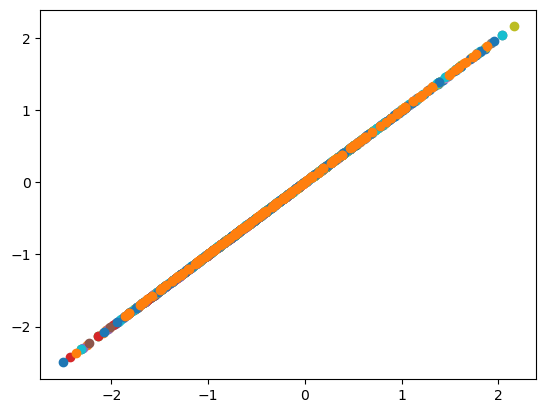

In [41]:
# check against Nino3.4rel:
for m in range(12):
    plt.scatter(nino34_det.groupby("time.month")[m+1], nino34_rel.groupby("time.month")[m+1] / m_adj[m] - m_mean.sel(month = m+1))

In [11]:
# save everything as .csv for easier transfer to R
nino34.to_pandas().to_csv("nino34.csv")
sst_anom.to_pandas().to_csv("sst_anom.csv")
nino34_det.to_pandas().to_csv("nino34_det.csv")
nino34_rel.to_pandas().to_csv("nino34_rel.csv")

## **How is the scaling factor derived?**

On the scaling factor used:  
`A technical point is that this index will have a 20% smaller variability than the original Niño3.4 index, as a large part of the interannual variability of the 20∘ S–20∘ N series is also ENSO-driven. This is not acceptable for users who rely on fixed categorical thresholds to define events, such as the NOAA thresholds of ±0.5$^\circ$C. In addition, statistical models that use the Niño3.4 index would need refitting. We therefore propose to renormalize the series to the same variability as the original Niño3.4 series by multiplying by 1/(1 − A) with A the regression of the 20∘ S–20∘ N SST anomalies on the Niño3.4 index after taking year-on-year differences to isolate the ENSO signal. The regression has a strong seasonal cycle, so it is determined for each month separately (averaging over the two adjoining months in the fit to increase the signal/noise ratio`

Still not quite sure what this means in practice - however, when using Nino3.4 as a covariate in a linear model, the difference in variability will be absorbed into the fitted coefficient, so this step shouldn't matter.